## 色彩追蹤

### 程式目的、輸入、與輸出
#### 目的
使用 OpenCV 與 PyQt5 實作的 即時多物體色彩追蹤系統，主要功能是：

使用攝影機擷取畫面

對畫面中符合指定 HSV 色域範圍的物體進行追蹤

將每個物體編號、畫框、標示中心座標

顯示物體與畫面中心的水平偏差值

提供 GUI 操作介面調整參數與即時觀察影像結果

### 輸入

1. 實體輸入

    攝影機影像串流（透過 OpenCV cv2.VideoCapture）

    顏色範圍偵測參數（由 GUI 控制）

2. 使用者透過 GUI 可調整的參數：
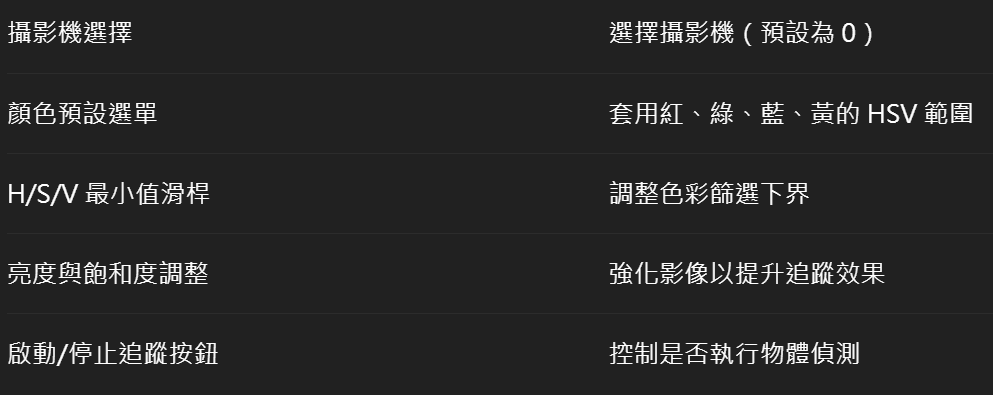

### 輸出
1. 畫面輸出（即時顯示於 GUI）：
原始影像：加亮/飽和處理後的畫面

    追蹤畫面：

        物體框線（綠色）

        物體中心（紅點）

        物體編號與座標（藍字）

2. 資訊欄文字輸出：
    顯示所有偵測到的物體資訊：  
             物體1: 中心=(325, 220) 偏差=15  
             物體2: 中心=(450, 210) 偏差=-110  

##### AI提示語  
想製作影像辨識顏色物體並有python程式介面  
介面請用PyQt5製作 想要有可以調亮度 選要跟蹤的顏色  
想用下拉式選單選我要的相機  
兩個相機視窗 一個原圖 一個顯示追蹤的色塊  
顯示目前物體的中心值還有與畫面中心的偏差值  
增加HSV調整(有色域預覽) 還有亮度跟飽和度要時實顯示在畫面上並增加重置按鈕 
可調整 H/S/V ± 範圍改成 整條色域 開頭與結尾都是紅色 有兩端拉感控制  
常用的幾種顏色一鍵套用 用下拉式選單  
如果有很多物體 都抓出來並編號  
物體的編號是已經判定完area < 200後的編號 由左至右 由上到下 (左上為原點)  

測試影片：https://www.youtube.com/watch?v=-_Kvzn-G8UE


In [ ]:
import sys
import cv2
import numpy as np
from PyQt5 import QtWidgets, QtGui, QtCore

class VideoThread(QtCore.QThread):
    original_frame_signal = QtCore.pyqtSignal(np.ndarray)
    tracked_frame_signal = QtCore.pyqtSignal(np.ndarray)
    center_info_signal = QtCore.pyqtSignal(str)

    def __init__(self, cam_index=0):
        super().__init__()
        self._run_tracking = False
        self.cam_index = cam_index
        self.brightness = 0
        self.saturation = 0
        self.hue_min = 40
        self.hue_max = 80
        self.s_min = 50
        self.v_min = 50
        self.capture = None

    def run(self):
        self.capture = cv2.VideoCapture(self.cam_index)
        while True:
            ret, frame = self.capture.read()
            if not ret:
                continue

            # 將 BGR 影像轉為 HSV 色彩空間
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # 調整亮度與飽和度（S 與 V）
            hsv[..., 2] = np.clip(hsv[..., 2] + self.brightness, 0, 255)
            hsv[..., 1] = np.clip(hsv[..., 1] + self.saturation, 0, 255)

            # 將調整後的 HSV 轉回 BGR 以供顯示
            adjusted_frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            self.original_frame_signal.emit(adjusted_frame.copy())

            tracked_frame = adjusted_frame.copy()
            info_text = "中心位置: -, 偏差值: -"

            if self._run_tracking:
                # 定義 HSV 遮罩範圍
                h_min = min(self.hue_min, self.hue_max)
                h_max = max(self.hue_min, self.hue_max)
                lower = np.array([h_min, self.s_min, self.v_min])
                upper = np.array([h_max, 255, 255])

                # 建立遮罩（符合顏色範圍）
                mask = cv2.inRange(hsv, lower, upper)

                # 尋找遮罩中的輪廓（物體）
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    img_center_x = frame.shape[1] // 2
                    info_texts = []

                    filtered_contours = []
                    for c in contours:
                        area = cv2.contourArea(c)
                        if area >= 200:
                            x, y, w, h = cv2.boundingRect(c)
                            filtered_contours.append((c, x, y))

                    # 按照 (y, x) 進行位置排序
                    filtered_contours.sort(key=lambda item: (item[2], item[1]))

                    for i, (c, x, y) in enumerate(filtered_contours):
                        w, h = cv2.boundingRect(c)[2:]
                        cx = x + w // 2
                        cy = y + h // 2
                        error = img_center_x - cx

                        # 在追蹤畫面上畫出矩形框、中心點與編號文字
                        cv2.rectangle(tracked_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        cv2.circle(tracked_frame, (cx, cy), 4, (0, 0, 255), -1)
                        cv2.putText(tracked_frame, f"#{i+1} ({cx},{cy})", (x, y - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                        info_texts.append(f"物體{i+1}: 中心=({cx},{cy}) 偏差={error}")

                    info_text = "\n".join(info_texts)
                else:
                    info_text = "未偵測到物體"

            self.center_info_signal.emit(info_text)
            self.tracked_frame_signal.emit(tracked_frame)

    def start_tracking(self):
        self._run_tracking = True

    def stop_tracking(self):
        self._run_tracking = False

class ColorTrackingUI(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("追蹤系統")
        self.setGeometry(100, 100, 800, 1050)
        self.thread = None
        self.initUI()

    def initUI(self):
        layout = QtWidgets.QVBoxLayout()

        self.original_label = QtWidgets.QLabel()
        self.original_label.setFixedSize(640, 360)
        self.tracked_label = QtWidgets.QLabel()
        self.tracked_label.setFixedSize(640, 360)
        self.center_info = QtWidgets.QLabel()
        self.center_info.setAlignment(QtCore.Qt.AlignTop)
        self.center_info.setWordWrap(True)
        self.center_info.setFixedHeight(100)

        layout.addWidget(QtWidgets.QLabel("原始畫面", alignment=QtCore.Qt.AlignCenter))
        layout.addWidget(self.original_label)
        layout.addWidget(QtWidgets.QLabel("追蹤畫面", alignment=QtCore.Qt.AlignCenter))
        layout.addWidget(self.tracked_label)
        layout.addWidget(self.center_info)

        self.cam_combo = QtWidgets.QComboBox()
        self.cam_combo.addItems(["0", "1", "2"])

        self.hue_label = QtWidgets.QLabel()
        self.hue_label.setPixmap(QtGui.QPixmap(self.generate_hue_pixmap(640, 20)))

        self.h_min_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.h_min_slider.setRange(0, 179)
        self.h_min_slider.setValue(40)

        self.h_max_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.h_max_slider.setRange(0, 179)
        self.h_max_slider.setValue(80)

        self.s_min_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.s_min_slider.setRange(0, 255)
        self.s_min_slider.setValue(50)

        self.v_min_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.v_min_slider.setRange(0, 255)
        self.v_min_slider.setValue(50)

        self.brightness_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.brightness_slider.setRange(-100, 100)
        self.brightness_slider.setValue(0)

        self.saturation_slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.saturation_slider.setRange(-100, 100)
        self.saturation_slider.setValue(0)

        self.reset_button = QtWidgets.QPushButton("重置亮度/飽和度")
        self.start_button = QtWidgets.QPushButton("啟動追蹤")
        self.stop_button = QtWidgets.QPushButton("停止追蹤")

        self.color_combo = QtWidgets.QComboBox()
        self.color_combo.addItems(["請選擇預設色域", "紅色", "綠色", "藍色", "黃色"])
        self.color_combo.currentTextChanged.connect(self.apply_preset_color)

        form = QtWidgets.QFormLayout()
        form.addRow("選擇攝影機：", self.cam_combo)
        form.addRow("套用常用顏色：", self.color_combo)
        form.addRow("Hue 色彩條：", self.hue_label)
        form.addRow("H最小值：", self.h_min_slider)
        form.addRow("H最大值：", self.h_max_slider)
        form.addRow("S最小值：", self.s_min_slider)
        form.addRow("V最小值：", self.v_min_slider)
        form.addRow("亮度調整：", self.brightness_slider)
        form.addRow("飽和度調整：", self.saturation_slider)
        form.addRow(self.reset_button)
        form.addRow(self.start_button, self.stop_button)

        layout.addLayout(form)
        self.setLayout(layout)

        self.cam_combo.currentIndexChanged.connect(self.init_video_thread)
        self.reset_button.clicked.connect(self.reset_brightness_saturation)
        self.start_button.clicked.connect(self.start_tracking)
        self.stop_button.clicked.connect(self.stop_tracking)

    def reset_brightness_saturation(self):
        self.brightness_slider.setValue(0)
        self.saturation_slider.setValue(0)

    def generate_hue_pixmap(self, width, height):
        hue_strip = np.zeros((height, width, 3), dtype=np.uint8)
        for x in range(width):
            hue = int((x / width) * 179)
            hue_strip[:, x] = [hue, 255, 255]
        bgr = cv2.cvtColor(hue_strip, cv2.COLOR_HSV2BGR)
        qimg = QtGui.QImage(bgr.data, width, height, 3 * width, QtGui.QImage.Format_RGB888).rgbSwapped()
        return QtGui.QPixmap.fromImage(qimg)

    def init_video_thread(self):
        if self.thread:
            self.thread.terminate()

        cam_index = int(self.cam_combo.currentText())
        self.thread = VideoThread(cam_index)

        self.brightness_slider.valueChanged.connect(lambda val: setattr(self.thread, 'brightness', val))
        self.saturation_slider.valueChanged.connect(lambda val: setattr(self.thread, 'saturation', val))
        self.h_min_slider.valueChanged.connect(lambda val: setattr(self.thread, 'hue_min', val))
        self.h_max_slider.valueChanged.connect(lambda val: setattr(self.thread, 'hue_max', val))
        self.s_min_slider.valueChanged.connect(lambda val: setattr(self.thread, 's_min', val))
        self.v_min_slider.valueChanged.connect(lambda val: setattr(self.thread, 'v_min', val))

        self.thread.original_frame_signal.connect(self.update_original)
        self.thread.tracked_frame_signal.connect(self.update_tracked)
        self.thread.center_info_signal.connect(self.update_info)

        self.thread.start()

    def start_tracking(self):
        if self.thread:
            self.thread.start_tracking()

    def stop_tracking(self):
        if self.thread:
            self.thread.stop_tracking()

    def update_original(self, cv_img):
        qt_img = self.convert_cv_qt(cv_img)
        self.original_label.setPixmap(qt_img)

    def update_tracked(self, cv_img):
        qt_img = self.convert_cv_qt(cv_img)
        self.tracked_label.setPixmap(qt_img)

    def update_info(self, text):
        self.center_info.setText(text)

    def apply_preset_color(self, color):
        presets = {
            "紅色": (0, 10),
            "黃色": (20, 35),
            "綠色": (40, 85),
            "藍色": (100, 130)
        }
        if color in presets:
            hmin, hmax = presets[color]
            self.h_min_slider.setValue(hmin)
            self.h_max_slider.setValue(hmax)

    def convert_cv_qt(self, cv_img):
        rgb_image = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
        h, w, ch = rgb_image.shape
        bytes_per_line = ch * w
        qt_image = QtGui.QImage(rgb_image.data, w, h, bytes_per_line, QtGui.QImage.Format_RGB888)
        return QtGui.QPixmap.fromImage(qt_image).scaled(640, 360, QtCore.Qt.KeepAspectRatio)

def run_app():
    app = QtWidgets.QApplication(sys.argv)
    window = ColorTrackingUI()
    window.show()
    sys.exit(app.exec_())

run_app()


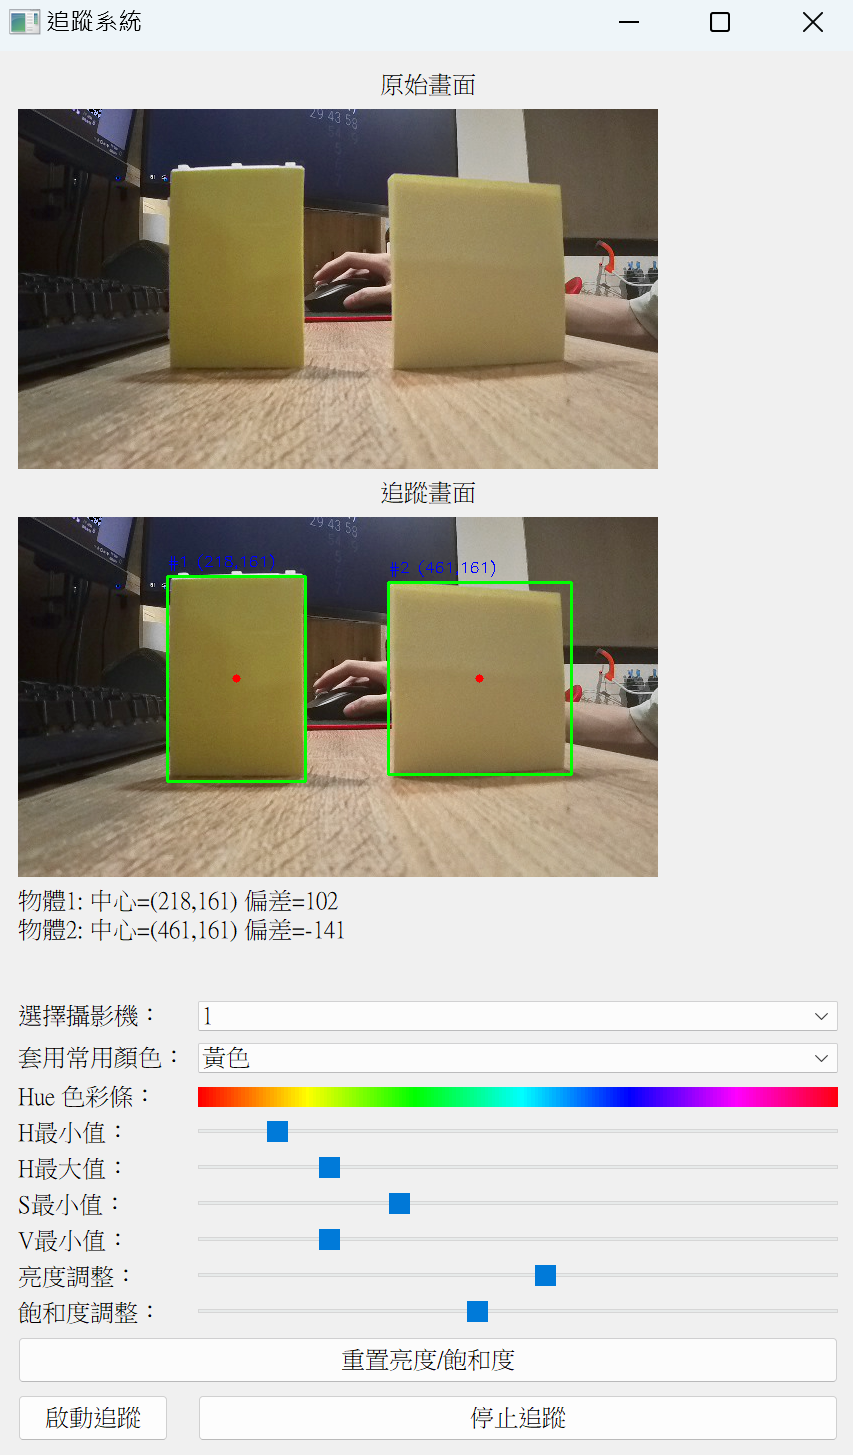